# Top Hit Song Prediction
This is to test the top song prediction.

## Dependecy
Here are the depedency that I'm currently using to helping run the prediction and handling the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

## Cleaning Data
Before we begin with anything, the data should be cleaned first.

### Remove Missing Data
For High popularity

In [2]:
# Add csv data to songs
high_song_popularity = pd.read_csv("high_popularity_spotify_data.csv")

# Drop useless column
high_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Show the total number of null in each column.
print(high_song_popularity.isnull().sum())

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_name                  0
track_album_release_date    0
instrumentalness            0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
dtype: int64


For low popularity

In [3]:
# Add csv data to songs
low_song_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Drop useless column
low_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Drop row containing null for time_signature
low_song_popularity = low_song_popularity.dropna(subset='time_signature')

# Show the total number of null in each column.
print(low_song_popularity.isnull().sum())

time_signature              0
track_popularity            0
speechiness                 0
danceability                0
track_artist                0
duration_ms                 0
energy                      0
playlist_genre              0
playlist_subgenre           0
track_name                  0
mode                        0
track_album_release_date    0
id                          0
instrumentalness            0
valence                     0
key                         0
tempo                       0
loudness                    0
acousticness                0
liveness                    0
dtype: int64


## Visualization and analyze trends


### Popular vs Non-popular


In [5]:
# Features that are 0. something
normalize_features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness']
raw_features = ['tempo', 'loudness']

# Calculate averages
popularity_avarage_norm = high_song_popularity[normalize_features].mean()
non_popularity_avarage_norm = low_song_popularity[normalize_features].mean()

popularity_avarage_raw = high_song_popularity[raw_features].mean()
non_popularity_avarage_raw = low_song_popularity[raw_features].mean()

high_popularity_avg = high_song_popularity['track_popularity'].mean()
low_popularity_avg = low_song_popularity['track_popularity'].mean()

max_popular_high_popularity = high_song_popularity['track_popularity'].max()
max_popular_low_popularity = low_song_popularity['track_popularity'].max()

min_popular_high_popularity = high_song_popularity['track_popularity'].min()
min_popular_low_popularity = low_song_popularity['track_popularity'].min()

count_max_popular_high_popularity = (high_song_popularity['track_popularity'] == 100).sum()
count_max_popular_low_popularity = (low_song_popularity['track_popularity'] == 68).sum()

count_min_popular_high_popularity = (high_song_popularity['track_popularity'] == 68).sum()
count_min_popular_low_popularity = (low_song_popularity['track_popularity'] == 11).sum()

# Show
print('popular track for high avarage popularity:', high_popularity_avg)
print('max popular track for high avarage popularity:', max_popular_high_popularity)
print('min popular track for high avarage popularity:', min_popular_high_popularity)
print('features for popularity')
print(popularity_avarage_norm)
print(popularity_avarage_raw)

print('popular track for low avarage popularity:', low_popularity_avg)
print('max popular track for low avarage popularity:', max_popular_low_popularity)
print('min popular track for low avarage popularity:', min_popular_low_popularity)
print('features for non popularity')
print(non_popularity_avarage_norm)
print(non_popularity_avarage_raw)

print('the number of high popularity for 68: ', count_min_popular_high_popularity, ' and for low popularity for 68:', count_max_popular_low_popularity)

# Create normalize feature chart
fig_norm = go.Figure(data=[
    go.Bar(name='Popular songs', x=normalize_features, y=popularity_avarage_norm, marker_color='green'),
    go.Bar(name='Non-popular songs', x=normalize_features, y=non_popularity_avarage_norm, marker_color='blue')
])

fig_norm.update_layout(
    title='Normalize Feature Comparison: Popular vs. Non-Popular Songs',
    xaxis_title='Features',
    yaxis_title='Average (0 - 1 scale)',
    barmode='group',
    template='plotly_dark',
    height=500
)

# Create raw features chart
fig_raw = go.Figure(data=[
    go.Bar(name= 'Popular songs', x=raw_features, y=popularity_avarage_raw, marker_color='green'),
    go.Bar(name='Non-popular songs', x=raw_features, y=non_popularity_avarage_raw, marker_color='blue')
])

fig_raw.update_layout(
    title='Raw Feature Comparison: Popular vs. Non-Popular Songs',
    xaxis_title='Features',
    yaxis_title='Raw Average Value (Tempo = BPM, Loudness = dB)',
    barmode='group',
    template='plotly_dark',
    height=500
)

fig_norm.show()
fig_raw.show()

popular track for high avarage popularity: 75.80604982206405
max popular track for high avarage popularity: 100
min popular track for high avarage popularity: 68
features for popularity
energy              0.667216
danceability        0.650362
valence             0.525737
acousticness        0.221220
instrumentalness    0.041520
dtype: float64
tempo       121.070938
loudness     -6.704131
dtype: float64
popular track for low avarage popularity: 43.47709923664122
max popular track for low avarage popularity: 68
min popular track for low avarage popularity: 11
features for non popularity
energy              0.543509
danceability        0.607268
valence             0.458438
acousticness        0.405567
instrumentalness    0.286603
dtype: float64
tempo       116.766884
loudness    -10.663833
dtype: float64
the number of high popularity for 68:  124  and for low popularity for 68: 45


### Global hits popularity per month
This is to show the top 50 avarge popurarity per month for the global top 50.

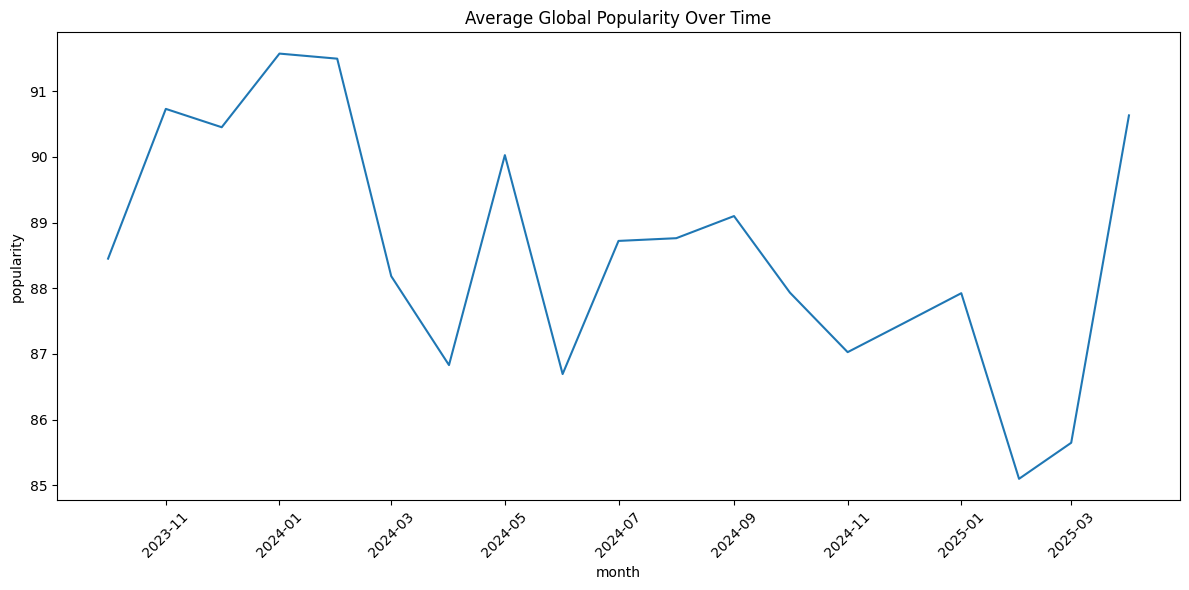

In [21]:
# Convert snapshot_date to datetime
#songs['snapshot_date'] = pd.to_datetime(songs['snapshot_date'])

#print(songs['snapshot_date'])

# Filter country to Global
global_songs = songs[songs['country'] == 'Global'].copy()

# Extract month from the date
global_songs['month'] = global_songs['snapshot_date'].dt.to_period('M')

#print(global_songs['month'])

# Group by month and calculate avarage popularity per month
monthly_popularity = global_songs.groupby('month')['popularity'].mean().reset_index()

# Cobvert month by to back to datetime for plotting
monthly_popularity['month'] = monthly_popularity['month'].dt.to_timestamp()

#print(monthly_popularity['month'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_popularity, x='month', y='popularity')
plt.title('Average Global Popularity Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Which countries have the most popular songs?


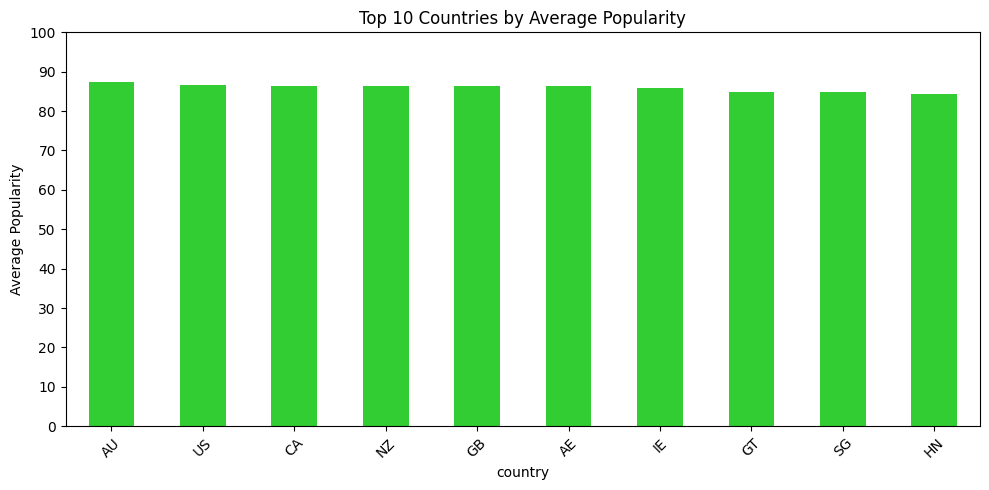

In [20]:
# Filter out 'Global' from the dataset
songs_without_global = songs[songs['country'] != 'Global']

# Group by countries with arverage popularity in descending order and show top 10
top_countries = songs_without_global.groupby('country')['popularity'].mean().sort_values(ascending=False).head(10)

top_countries.plot(kind='bar', figsize=(10, 5), color='limegreen')
plt.title('Top 10 Countries by Average Popularity')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.yticks(range(0, 110, 10))
plt.tight_layout()
plt.show()


In [11]:
songs['snapshot_date'] = pd.to_datetime(songs['snapshot_date'])
songs['snapshot_month'] = songs['snapshot_date'].dt.to_period('M')

songs['country'] = songs['country'].fillna('Global')

sports_cars_song = songs[(songs['name'] == 'Die With A Smile') & (songs['country'] == 'Global')]

sports_cars_monthly_global = (sports_cars_song.groupby(['snapshot_month', 'country', 'name'])['popularity'].mean().reset_index().sort_values(['snapshot_month', 'country']))

sports_cars_monthly_global

,snapshot_month,country,name,popularity
0,2024-08,Global,Die With A Smile,82.133333
1,2024-09,Global,Die With A Smile,98.133333
2,2024-10,Global,Die With A Smile,100.000000
3,2024-11,Global,Die With A Smile,99.814815
4,2024-12,Global,Die With A Smile,99.083333
5,2025-01,Global,Die With A Smile,99.967742
6,2025-02,Global,Die With A Smile,98.357143
7,2025-03,Global,Die With A Smile,80.129032
8,2025-04,Global,Die With A Smile,88.000000


In [15]:
songs['snapshot_date'] = pd.to_datetime(songs['snapshot_date'])
songs['snapshot_month'] = songs['snapshot_date'].dt.to_period('M')

songs['country'] = songs['country'].fillna('Global')

sports_cars_song_global = songs[(songs['name'] == 'Die With A Smile') & (songs['country'] == 'Global')]

filtered_data = sports_cars_song_global[(sports_cars_song_global['snapshot_date'] >= '2025-02-01') &
                                        (sports_cars_song_global['snapshot_date'] <= '2025-02-28')]

filtered_data = filtered_data[['snapshot_date', 'name', 'country', 'popularity']].sort_values('snapshot_date')

filtered_data

,snapshot_date,name,country,popularity
216370,2025-02-01,Die With A Smile,Global,100
212770,2025-02-02,Die With A Smile,Global,100
209170,2025-02-03,Die With A Smile,Global,100
205570,2025-02-04,Die With A Smile,Global,100
201970,2025-02-05,Die With A Smile,Global,100
198370,2025-02-06,Die With A Smile,Global,99
194770,2025-02-07,Die With A Smile,Global,99
191120,2025-02-08,Die With A Smile,Global,99
187520,2025-02-09,Die With A Smile,Global,99
183920,2025-02-10,Die With A Smile,Global,99
